In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.feature_extraction import DataSource
from pals.pathway_analysis import PALS
from pals.common import *

2019-12-23 01:41:44.912 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-12-23 01:41:44.912 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-12-23 01:41:45.981 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

Try generating some synthetic data without noise

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
sample_fnames = control_fnames + case_fnames

pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
background_pathways = 10

(338, 8)
{'two': 2, 'four': 4, 'six': 6, 'ten': 10, 'twenty': 20, 'forty': 40, 'eighty': 80, 'background0': 35, 'background1': 8, 'background2': 11, 'background3': 20, 'background4': 21, 'background5': 25, 'background6': 8, 'background7': 27, 'background8': 11, 'background9': 10}


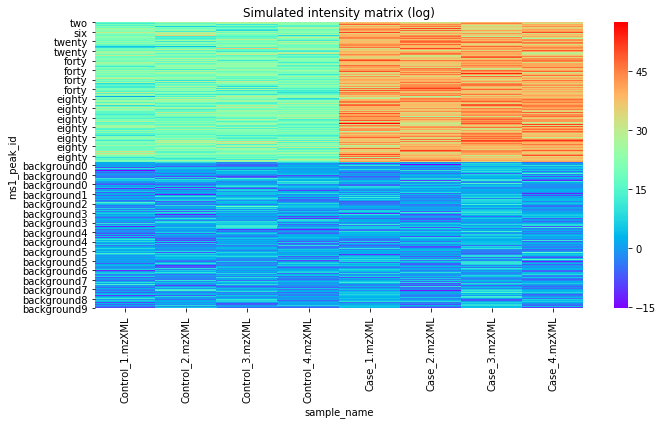

In [7]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=background_pathways)
print(int_df.shape)
print(updated_pathway_names)
plot_intensity_matrix(int_df)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [8]:
min_replace = 5000
plage_weight = 5
hg_weight = 1
prob_missing_peaks = 0.2

In [9]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks)
pals = PALS(ds, min_replace=min_replace, plage_weight=plage_weight, hg_weight=hg_weight)

2019-12-23 01:41:46.634 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 338
2019-12-23 01:41:46.635 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 270 with prob_missing_peaks=0.20
2019-12-23 01:41:46.636 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2019-12-23 01:41:46.636 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-23 01:41:46.637 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-23 01:41:46.658 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [10]:
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2019-12-23 01:41:46.736 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-23 01:41:46.751 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2019-12-23 01:41:46.754 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [-0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0.  0.
  0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0. -0.  0.  0.
  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.
  0.  0. -0.  0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0.
  0. -0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0.
  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0. -0

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,35,29,82.86,0.418281,27.96,79.89,1.000000
background1,background1,1.000000,8,6,75.00,0.796283,6.39,79.88,1.000000
background2,background2,0.837546,11,8,72.73,0.839572,8.79,79.91,0.876973
background3,background3,0.994298,20,18,90.00,0.194060,15.98,79.90,0.989602
background4,background4,0.986334,21,14,66.67,0.960785,16.78,79.90,0.993947
background5,background5,1.000000,25,18,72.00,0.896376,19.97,79.88,1.000000
background6,background6,1.000000,8,5,62.50,0.944832,6.39,79.88,1.000000
background7,background7,1.000000,27,22,81.48,0.530621,21.57,79.89,1.000000
background8,background8,1.000000,11,10,90.91,0.314181,8.79,79.91,1.000000
background9,background9,0.288427,10,6,60.00,0.968600,7.99,79.90,0.427691


In [11]:
ora_df = pals.get_ora_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2019-12-23 01:41:47.996 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-23 01:41:47.997 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-23 01:41:48.016 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=background3 comp=case/control M=338 n=139 N=20 k=2 sf=0.999728
2019-12-23 01:41:48.020 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=twenty comp=case/control M=338 n=139 N=20 k=13 sf=0.023381
2019-12-23 01:41:48.024 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=forty comp=case/control M=338 n=139 N=40 k=30 sf=0.000004
2019-12-23 01:41:48.029 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=background9 comp=case/control M=338 n=139 N=10 k=1 sf=0.995451
2019-12-23 01:41:48.033 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=eighty comp=case/control M=338 n=139 N=80 k=72 sf=0.000000
2019-12-23 01:41:48.037 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=

,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
background0,background0,1.000000e+00,1.000000e+00,35,29,82.86
background1,background1,1.000000e+00,1.000000e+00,8,6,75.00
background2,background2,1.000000e+00,1.000000e+00,11,8,72.73
background3,background3,9.997278e-01,1.000000e+00,20,18,90.00
background4,background4,1.000000e+00,1.000000e+00,21,14,66.67
background5,background5,9.999991e-01,1.000000e+00,25,18,72.00
background6,background6,1.000000e+00,1.000000e+00,8,5,62.50
background7,background7,1.000000e+00,1.000000e+00,27,22,81.48
background8,background8,1.000000e+00,1.000000e+00,11,10,90.91


Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

(500, 8)


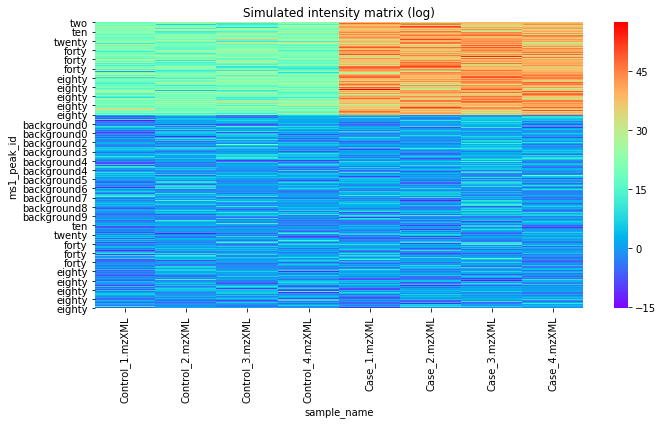

In [12]:
percent = 100
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [13]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks)
pals = PALS(ds, min_replace=min_replace, plage_weight=plage_weight, hg_weight=hg_weight)

2019-12-23 01:41:48.649 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 500
2019-12-23 01:41:48.652 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 400 with prob_missing_peaks=0.20
2019-12-23 01:41:48.653 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2019-12-23 01:41:48.654 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-23 01:41:48.654 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-23 01:41:48.688 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [14]:
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2019-12-23 01:41:48.771 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-23 01:41:48.788 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2019-12-23 01:41:48.794 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [-0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0.  0.
  0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0. -0.  0.  0.
  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.
  0.  0. -0.  0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0.
  0. -0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0.
  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0. -0

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,0.862870,35,26,74.29,0.862427,28.0,80.0,0.900795
background1,background1,0.999992,8,5,62.50,0.945195,6.4,80.0,0.999997
background2,background2,0.999773,11,10,90.91,0.319137,8.8,80.0,0.999590
background3,background3,0.935746,20,14,70.00,0.917585,16.0,80.0,0.961041
background4,background4,0.898311,21,17,80.95,0.586027,16.8,80.0,0.901459
background5,background5,0.999995,25,20,80.00,0.617733,20.0,80.0,0.999995
background6,background6,0.983813,8,7,87.50,0.502133,6.4,80.0,0.982103
background7,background7,0.979920,27,22,81.48,0.537593,21.6,80.0,0.978860
background8,background8,0.973042,11,6,54.55,0.989210,8.8,80.0,0.990376
background9,background9,0.664621,10,8,80.00,0.678418,8.0,80.0,0.694172


In [15]:
ora_df = pals.get_ora_df(correct_multiple_tests=False)
ora_df.sort_values('pw_name')

2019-12-23 01:41:50.217 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-23 01:41:50.218 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-23 01:41:50.240 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=background3 comp=case/control M=500 n=141 N=20 k=2 sf=0.989437
2019-12-23 01:41:50.243 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=twenty comp=case/control M=500 n=141 N=40 k=18 sf=0.013547
2019-12-23 01:41:50.248 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=forty comp=case/control M=500 n=141 N=80 k=32 sf=0.008841
2019-12-23 01:41:50.252 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=background9 comp=case/control M=500 n=141 N=10 k=1 sf=0.964872
2019-12-23 01:41:50.256 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw=eighty comp=case/control M=500 n=141 N=160 k=66 sf=0.000010
2019-12-23 01:41:50.260 | DEBUG    | pals.pathway_analysis:get_ora_df:93 - pw

,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
background0,background0,0.999994,0.999994,35,26,74.29
background1,background1,1.000000,1.000000,8,5,62.50
background2,background2,1.000000,1.000000,11,10,90.91
background3,background3,0.989437,0.989437,20,14,70.00
background4,background4,1.000000,1.000000,21,17,80.95
background5,background5,1.000000,1.000000,25,20,80.00
background6,background6,1.000000,1.000000,8,7,87.50
background7,background7,0.998784,0.998784,27,22,81.48
background8,background8,1.000000,1.000000,11,6,54.55


### Experiments

The following are all the methods we need to run our experiments

In [16]:
def run_experiment(reqd_scenarios, sample_fnames, pathway_names, num_iterations):
    pals_dfs = []
    ora_dfs = []
    for i in range(len(reqd_scenarios)):
        scenario = reqd_scenarios[i]
        logger.info(scenario)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', r'divide by zero')
            results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations, 
                                  percent=scenario['percent'], random=scenario['random'], noise_std=scenario['noise_std'],
                                  prob_missing_peaks=scenario['prob_missing_peaks'], 
                                  background_pathways=scenario['background_pathways'])
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'pals')        
        pals_dfs.append(df)
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'ora')        
        ora_dfs.append(df)   

    pals_df = pd.concat(pals_dfs, axis=0)
    ora_df = pd.concat(ora_dfs, axis=0)
    return pals_df, ora_df

In [17]:
def calc_av_p_scores(sample_fnames, pathway_names, num_iterations, percent=0, random=False, 
                     noise_mean=0, noise_std=5, prob_missing_peaks=0.2, background_pathways=100):
    results = {
        'pals': [],
        'ora': []
    }
    
    set_log_level_info()
    for it in range(num_iterations):
        if it % 10 == 0:
            logger.info('Iteration %d' % it)

        # constructs the peak intensity dataframe, adding random peaks if necessary
        int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=random,
                                                       background_pathways=background_pathways)        
        int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
            
        ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks)        
        pals = PALS(ds, min_replace=5000, plage_weight=5, hg_weight=1)
        pathway_df = pals.get_pathway_df()
        ora_df = pals.get_ora_df(correct_multiple_tests=True)
        
        results['pals'].append(pathway_df)
        results['ora'].append(ora_df)

    set_log_level_debug()
    return results

In [18]:
def construct_single_box_df(results, random_peaks, prob_missing, noise_std, method):
    df = pd.concat(results[method], axis=0)
    columns = ['pathway', 'percent', 'prob_missing', 'noise_std', 'p_value', 'comb_p_value', 'method']
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df['pathway'] = list(df.index)
    box_plot_df['percent'] = float(random_peaks)
    box_plot_df['prob_missing'] = float(prob_missing)    
    box_plot_df['noise_std'] = float(noise_std)        
    box_plot_df['p_value'] = df['case/control p-value'].values
    box_plot_df['comb_p_value'] = df['case/control comb_p'].values
    box_plot_df['method'] = method
    box_plot_df = box_plot_df[~box_plot_df.pathway.str.contains("background")]
    return box_plot_df

In [19]:
NUM_ITERATIONS = 500

### Experiment 1: adding noise

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [20]:
prob_missing_peaks = 0.20
bg_pw = 100
random = False # whether to sample intensity data randomly or using pre-set values
reqd_scenarios = [
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 5000, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': bg_pw, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 10000, 'prob_missing_peaks': prob_missing_peaks },    
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-23 01:41:50.695 | INFO     | __main__:run_experiment:6 - {'background_pathways': 100, 'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2}
2019-12-23 01:41:50.697 | INFO     | __main__:calc_av_p_scores:11 - Iteration 0
2019-12-23 01:42:14.968 | INFO     | __main__:calc_av_p_scores:11 - Iteration 10
2019-12-23 01:42:38.369 | INFO     | __main__:calc_av_p_scores:11 - Iteration 20
2019-12-23 01:43:01.254 | INFO     | __main__:calc_av_p_scores:11 - Iteration 30
2019-12-23 01:43:25.060 | INFO     | __main__:calc_av_p_scores:11 - Iteration 40
2019-12-23 01:43:48.375 | INFO     | __main__:calc_av_p_scores:11 - Iteration 50
2019-12-23 01:44:11.242 | INFO     | __main__:calc_av_p_scores:11 - Iteration 60
2019-12-23 01:44:34.497 | INFO     | __main__:calc_av_p_scores:11 - Iteration 70
2019-12-23 01:44:57.160 | INFO     | __main__:calc_av_p_scores:11 - Iteration 80
2019-12-23 01:45:20.057 | INFO     | __main__:calc_av_p_scores:11 - Iteration 90


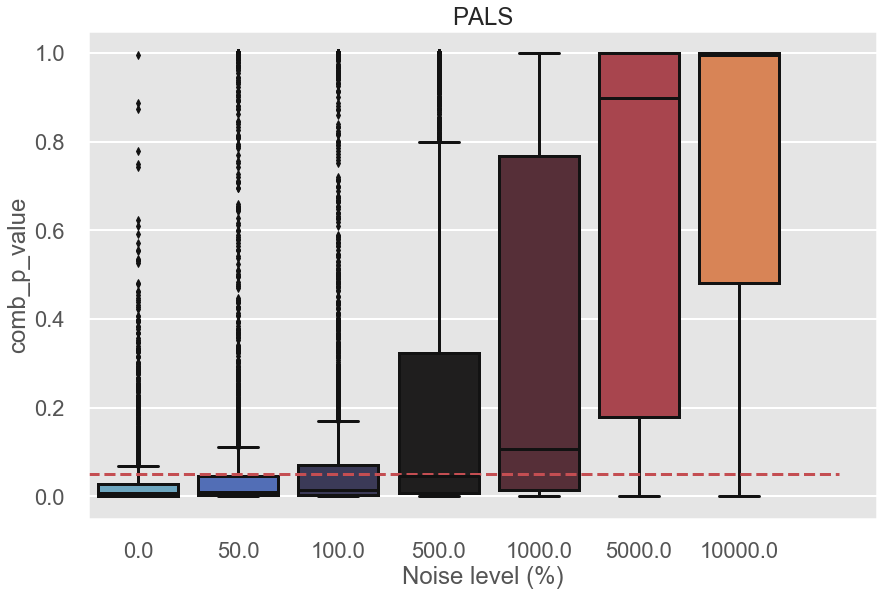

In [21]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="percent", y="comb_p_value", data=pals_df, palette=("icefire"))
# ax = sns.swarmplot(x="percent", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Noise level (%)', ylabel='comb_p_value')
plt.plot([-0.5, 7], [0.05, 0.05], 'r--')
plt.title('PALS')
plt.tight_layout()
plt.savefig('adding_noise_pals.eps', dpi=300)

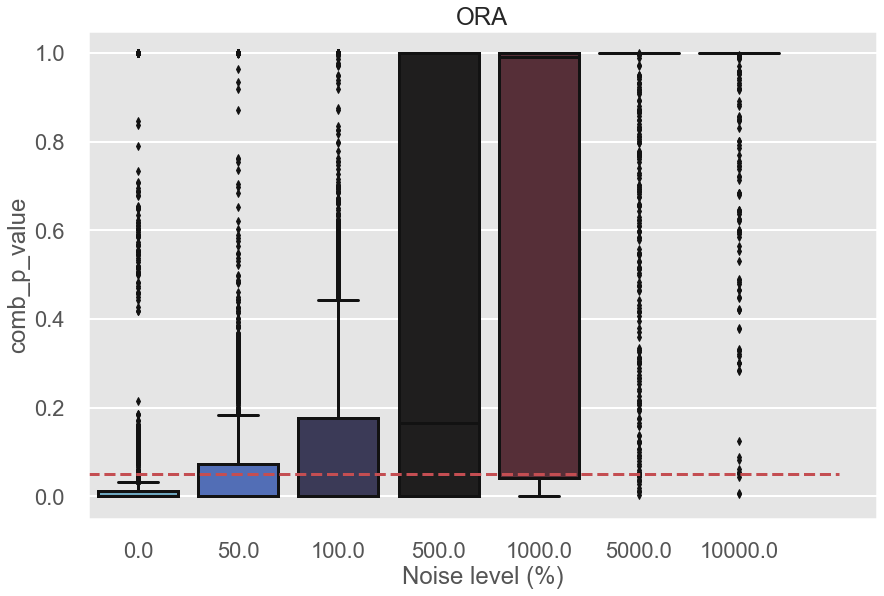

In [22]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="percent", y="comb_p_value", data=ora_df, palette=("icefire"))
# ax = sns.swarmplot(x="percent", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Noise level (%)', ylabel='comb_p_value')
plt.plot([-0.5, 7], [0.05, 0.05], 'r--')
plt.title('ORA')
plt.tight_layout()
plt.savefig('adding_noise_ora.eps', dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [23]:
percent = 100
random = False # whether to sample intensity data randomly or using pre-set values
bg_pw = 100
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.4, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.6, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.8, 'background_pathways': bg_pw },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-23 05:01:58.688 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2, 'background_pathways': 100}
2019-12-23 05:01:58.689 | INFO     | __main__:calc_av_p_scores:11 - Iteration 0
2019-12-23 05:02:22.256 | INFO     | __main__:calc_av_p_scores:11 - Iteration 10
2019-12-23 05:02:45.177 | INFO     | __main__:calc_av_p_scores:11 - Iteration 20
2019-12-23 05:03:08.195 | INFO     | __main__:calc_av_p_scores:11 - Iteration 30
2019-12-23 05:03:30.848 | INFO     | __main__:calc_av_p_scores:11 - Iteration 40
2019-12-23 05:03:53.879 | INFO     | __main__:calc_av_p_scores:11 - Iteration 50
2019-12-23 05:04:16.918 | INFO     | __main__:calc_av_p_scores:11 - Iteration 60
2019-12-23 05:04:39.825 | INFO     | __main__:calc_av_p_scores:11 - Iteration 70
2019-12-23 05:05:02.753 | INFO     | __main__:calc_av_p_scores:11 - Iteration 80
2019-12-23 05:05:25.815 | INFO     | __main__:calc_av_p_scores:11 - Iteration 9

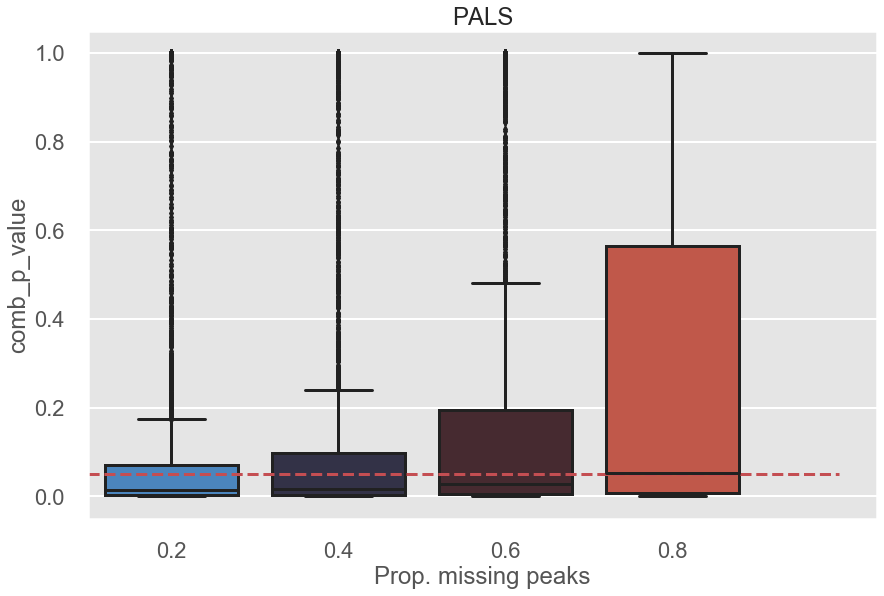

In [24]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="prob_missing", y="comb_p_value", data=pals_df, palette=("icefire"))
# ax = sns.swarmplot(x="prob_missing", y="comb_p_value", hue="pathway", data=pals_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Prop. missing peaks', ylabel='comb_p_value')
plt.plot([-0.5, 4], [0.05, 0.05], 'r--')
plt.title("PALS")
plt.tight_layout()
plt.savefig('missing_peaks_pals.eps', dpi=300)

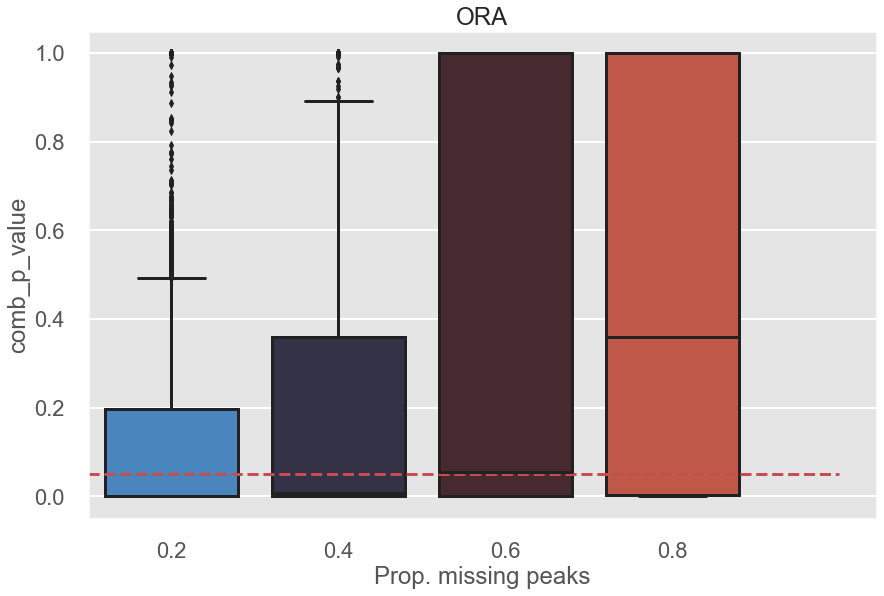

In [25]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="prob_missing", y="comb_p_value", data=ora_df, palette=("icefire"))
# ax = sns.swarmplot(x="prob_missing", y="comb_p_value", hue="pathway", data=ora_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Prop. missing peaks', ylabel='comb_p_value')
plt.plot([-0.5, 4], [0.05, 0.05], 'r--')
plt.title("ORA")
plt.tight_layout()
plt.savefig('missing_peaks_ora.eps', dpi=300)

### Experiment 3: pathway ranking vs noise level

Here we perform an experiment to see how the different methods rank pathways based on their size and in the presence of increasing noise.

#### Noise std deviation = 1

In [26]:
random = False # whether to sample intensity data randomly or using pre-set values
noise_std = 1
bg_pw = 100
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 5000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 10000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-23 06:15:52.390 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 1, 'percent': 0, 'prob_missing_peaks': 0.2, 'background_pathways': 100}
2019-12-23 06:15:52.391 | INFO     | __main__:calc_av_p_scores:11 - Iteration 0
2019-12-23 06:16:14.931 | INFO     | __main__:calc_av_p_scores:11 - Iteration 10
2019-12-23 06:16:37.663 | INFO     | __main__:calc_av_p_scores:11 - Iteration 20
2019-12-23 06:17:00.273 | INFO     | __main__:calc_av_p_scores:11 - Iteration 30
2019-12-23 06:17:23.203 | INFO     | __main__:calc_av_p_scores:11 - Iteration 40
2019-12-23 06:17:45.823 | INFO     | __main__:calc_av_p_scores:11 - Iteration 50
2019-12-23 06:18:08.604 | INFO     | __main__:calc_av_p_scores:11 - Iteration 60
2019-12-23 06:18:31.408 | INFO     | __main__:calc_av_p_scores:11 - Iteration 70
2019-12-23 06:18:54.272 | INFO     | __main__:calc_av_p_scores:11 - Iteration 80
2019-12-23 06:19:17.100 | INFO     | __main__:calc_av_p_scores:11 - Iteration 90


In [27]:
pals_df['pathway'] = pd.Categorical(pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['pathway'] = pd.Categorical(ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('pathway')
ora_df = ora_df.sort_values('pathway')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


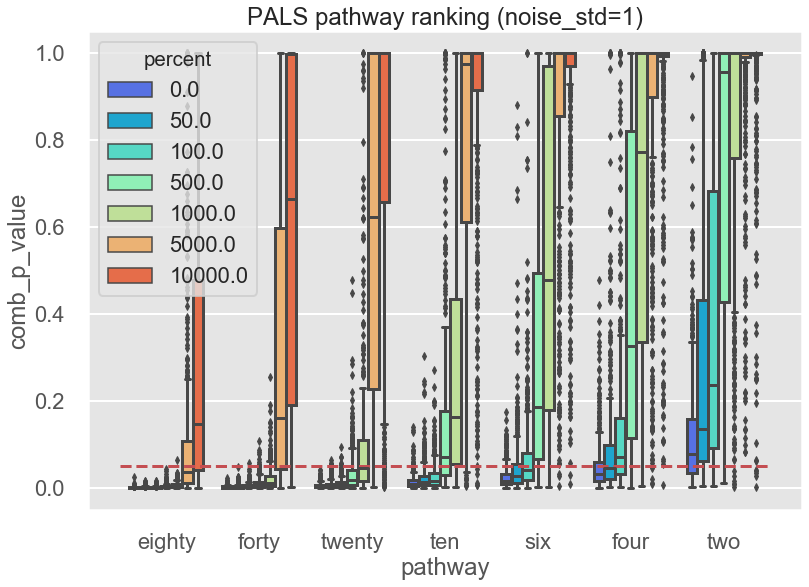

In [28]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=pals_df, palette=("rainbow"))
plt.title('PALS pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_pals_1.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


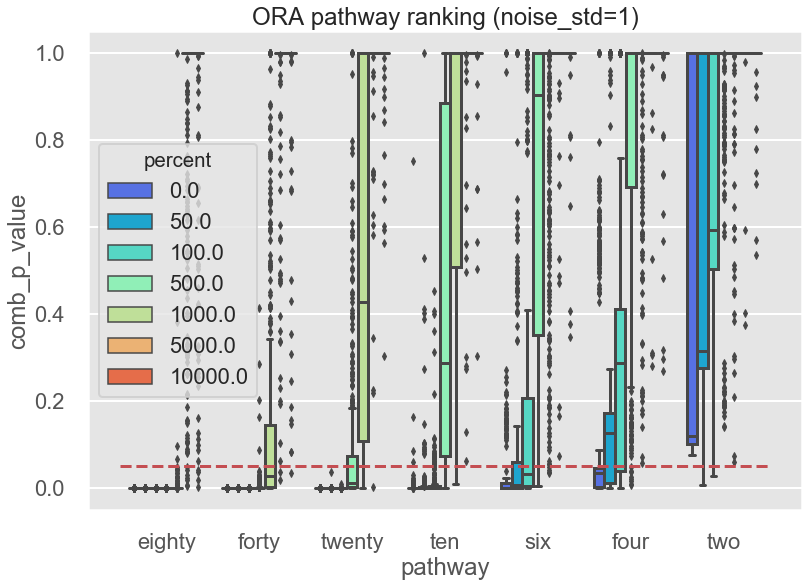

In [29]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=ora_df, palette=("rainbow"))
plt.title('ORA pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_ora_1.eps', dpi=300)

#### Noise std deviation = 5

In [30]:
random = False # whether to sample intensity data randomly or using pre-set values
noise_std = 5
bg_pw = 100
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 5000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 10000, 'prob_missing_peaks': 0.2, 'background_pathways': bg_pw },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-23 09:36:48.300 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2, 'background_pathways': 100}
2019-12-23 09:36:48.301 | INFO     | __main__:calc_av_p_scores:11 - Iteration 0
2019-12-23 09:37:10.924 | INFO     | __main__:calc_av_p_scores:11 - Iteration 10
2019-12-23 09:37:33.179 | INFO     | __main__:calc_av_p_scores:11 - Iteration 20
2019-12-23 09:37:55.772 | INFO     | __main__:calc_av_p_scores:11 - Iteration 30
2019-12-23 09:38:18.523 | INFO     | __main__:calc_av_p_scores:11 - Iteration 40
2019-12-23 09:38:41.312 | INFO     | __main__:calc_av_p_scores:11 - Iteration 50
2019-12-23 09:39:03.940 | INFO     | __main__:calc_av_p_scores:11 - Iteration 60
2019-12-23 09:39:26.955 | INFO     | __main__:calc_av_p_scores:11 - Iteration 70
2019-12-23 09:39:49.650 | INFO     | __main__:calc_av_p_scores:11 - Iteration 80
2019-12-23 09:40:12.459 | INFO     | __main__:calc_av_p_scores:11 - Iteration 90


In [31]:
pals_df['pathway'] = pd.Categorical(pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['pathway'] = pd.Categorical(ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('pathway')
ora_df = ora_df.sort_values('pathway')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


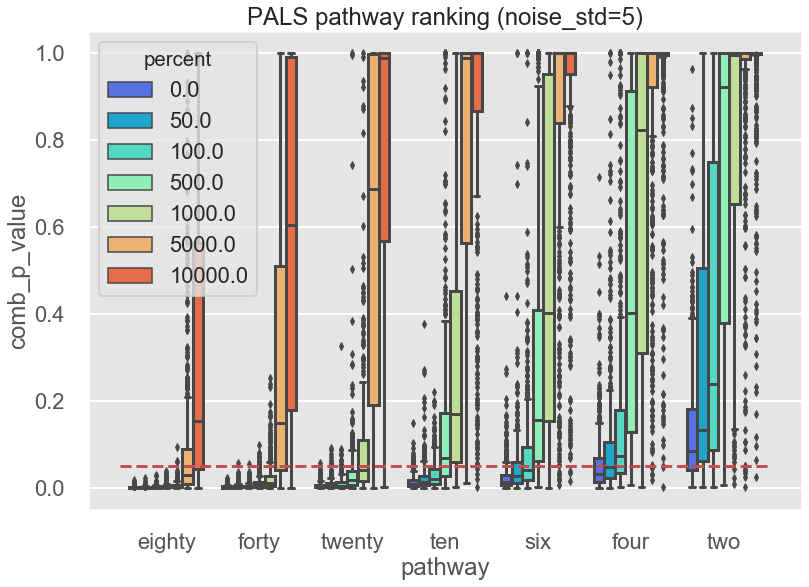

In [32]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=pals_df, palette=("rainbow"))
plt.title('PALS pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_pals_5.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


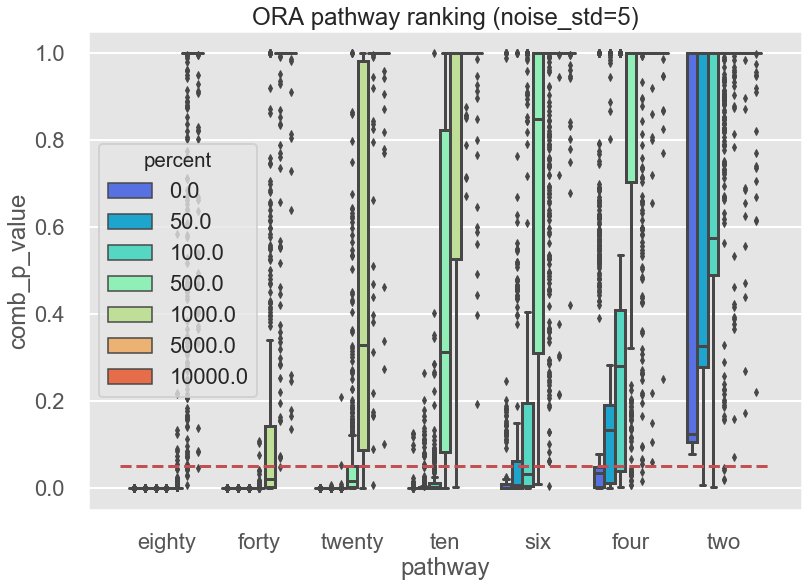

In [33]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=ora_df, palette=("rainbow"))
plt.title('ORA pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_ora_5.eps', dpi=300)

#### Nothing is changing, it's all random

In [34]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations=1, random=True)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'pals')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ora')   

2019-12-23 13:00:18.091 | INFO     | __main__:calc_av_p_scores:11 - Iteration 0


In [35]:
pals_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
27,forty,100.0,0.2,1.0,0.998360,0.997824,pals
64,twenty,100.0,0.2,1.0,0.907357,0.913676,pals
65,eighty,100.0,0.2,1.0,1.000000,1.000000,pals
67,ten,100.0,0.2,1.0,1.000000,1.000000,pals
81,four,100.0,0.2,1.0,1.000000,1.000000,pals
94,two,100.0,0.2,1.0,1.000000,1.000000,pals
98,six,100.0,0.2,1.0,1.000000,1.000000,pals


In [36]:
ora_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
27,forty,100.0,0.2,1.0,0.852454,1.0,ora
64,twenty,100.0,0.2,1.0,0.236692,1.0,ora
65,eighty,100.0,0.2,1.0,0.513556,1.0,ora
67,ten,100.0,0.2,1.0,1.000000,1.0,ora
81,four,100.0,0.2,1.0,1.000000,1.0,ora
94,two,100.0,0.2,1.0,1.000000,1.0,ora
98,six,100.0,0.2,1.0,0.248110,1.0,ora
